In [9]:
#Step 3
import wikipedia
import random
import os

def fetch_wiki_sentences(language_code, num_sentences=500):
    wikipedia.set_lang(language_code)
    sentences = []
    
    try:
        # Get random pages
        pages = wikipedia.random(pages=50)
        if isinstance(pages, str):
            pages = [pages]
        
        for page in pages:
            try:
                content = wikipedia.page(page).content
                content_sentences = content.split('.')
                content_sentences = [s.strip() for s in content_sentences if len(s.split()) > 5]
                sentences.extend(content_sentences)
                if len(sentences) >= num_sentences:
                    break
            except Exception:
                continue
    except Exception as e:
        print(f"Error fetching Wikipedia content: {e}")
    
    return sentences[:num_sentences]

def save_sentences(sentences, language_name):
    os.makedirs('corpora', exist_ok=True)
    path = os.path.join('corpora', f"{language_name}.txt")
    with open(path, 'w', encoding='utf-8') as f:
        for sentence in sentences:
            f.write(sentence.strip() + '\n')
    print(f"Saved {len(sentences)} sentences for {language_name}.")

# Updated language map with replacements
# Updated language map with replacements
# Updated language map with replacements
lang_map = {
    'english': 'en',
    'hindi': 'hi',
    'french': 'fr',
    'spanish': 'es',
    'german': 'de',
    'arabic': 'ar',
    'bengali': 'bn',    
    'odia': 'or',
    'afrikaans': 'af',  # Replaced Konkani
    'malay': 'ms',  # Replaced Georgian
    'urdu': 'ur'
}



# Main
if __name__ == "__main__":
    for lang, code in lang_map.items():
        print(f"Fetching sentences for {lang.title()}...")
        sents = fetch_wiki_sentences(code, num_sentences=500)
        save_sentences(sents, lang)

Fetching sentences for English...
Saved 500 sentences for english.
Fetching sentences for Hindi...
Saved 106 sentences for hindi.
Fetching sentences for French...


t:\nlp\.env\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file t:\nlp\.env\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Saved 500 sentences for french.
Fetching sentences for Spanish...
Saved 500 sentences for spanish.
Fetching sentences for German...
Saved 500 sentences for german.
Fetching sentences for Arabic...
Saved 400 sentences for arabic.
Fetching sentences for Bengali...
Saved 100 sentences for bengali.
Fetching sentences for Odia...
Saved 95 sentences for odia.
Fetching sentences for Afrikaans...
Saved 500 sentences for afrikaans.
Fetching sentences for Malay...
Saved 500 sentences for malay.
Fetching sentences for Urdu...
Saved 90 sentences for urdu.


Encoding afrikaans with 620 sentences...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Encoding arabic with 498 sentences...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Encoding bengali with 515 sentences...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Encoding english with 582 sentences...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Encoding french with 753 sentences...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Encoding german with 638 sentences...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Encoding hindi with 357 sentences...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Encoding malay with 557 sentences...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Encoding odia with 381 sentences...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Encoding spanish with 572 sentences...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Encoding urdu with 515 sentences...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

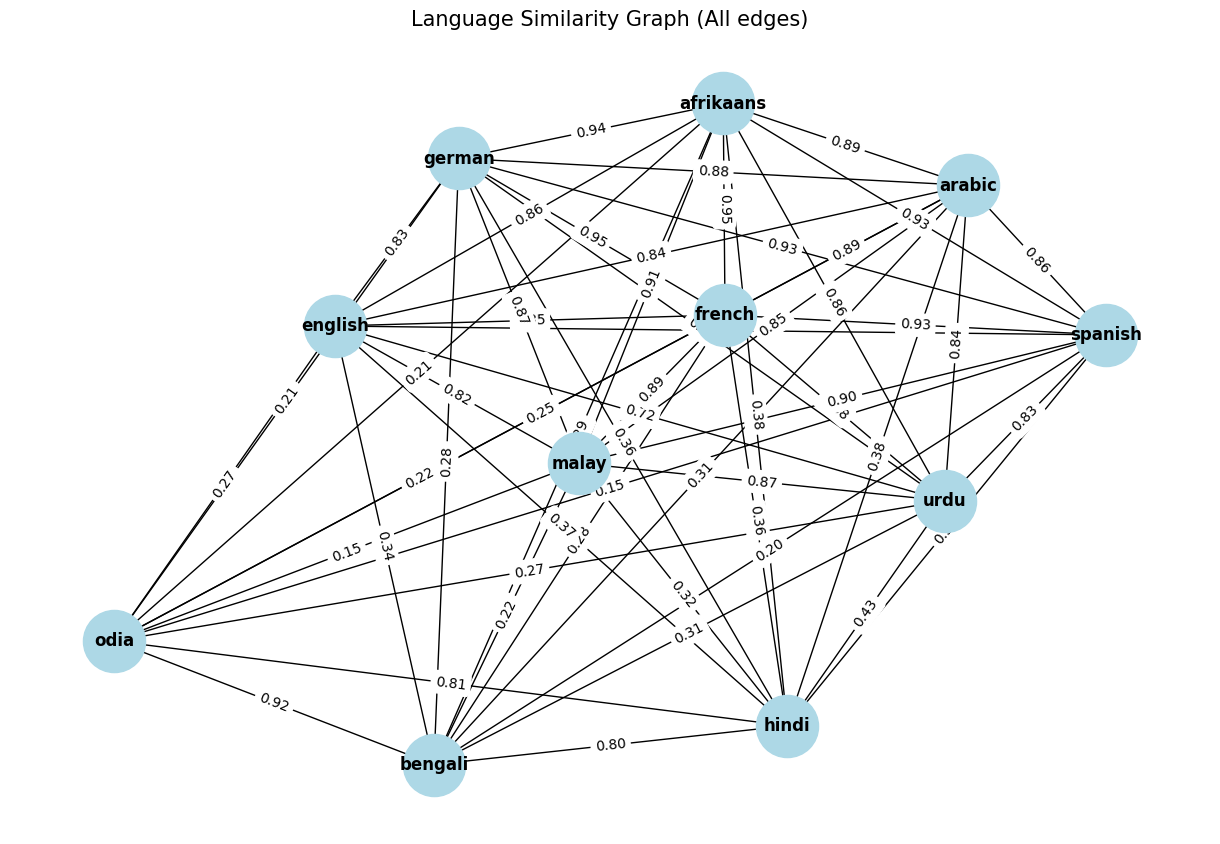

Graph saved as 'language_similarity_graph.gml'

Top Matches for Low-Resource Languages:

bengali → hindi (Similarity: 0.80)
odia → hindi (Similarity: 0.81)
afrikaans → french (Similarity: 0.95)
faroese → No match found!
urdu → french (Similarity: 0.88)


In [10]:
#Step 4
# # Imports

from sentence_transformers import SentenceTransformer
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import os
import re

# 1. Preprocessing Function
def preprocess_sentence(sentence):
    sentence = re.sub(r'={1,}', '', sentence)     # Remove headers ===
    sentence = re.sub(r'\[.*?\]', '', sentence)    # Remove [references]
    sentence = re.sub(r'\(.*?\)', '', sentence)    # Remove (info)
    sentence = re.sub(r'[^\w\s.,?!]', '', sentence) # Remove unwanted symbols
    sentence = re.sub(r'\s+', ' ', sentence).strip() # Collapse spaces
    return sentence

# 2. Load LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE')

# 3. Load and preprocess corpora
corpora_dir = 'corpora'
languages = [file.replace('.txt', '') for file in os.listdir(corpora_dir)]
corpora = {}

for lang in languages:
    with open(os.path.join(corpora_dir, lang + '.txt'), 'r', encoding='utf-8') as f:
        raw_sentences = f.read().splitlines()
        clean_sentences = [preprocess_sentence(s) for s in raw_sentences if len(s.split()) > 3]
        corpora[lang] = clean_sentences

# 4. Encode and Average embeddings
avg_embeddings = {}
for lang, sentences in corpora.items():
    print(f"Encoding {lang} with {len(sentences)} sentences...")
    embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True)
    avg_embeddings[lang] = np.mean(embeddings, axis=0)

# 5. Build Similarity Graph (All edges)
G = nx.Graph()

for i in range(len(languages)):
    for j in range(i+1, len(languages)):
        sim = 1 - cosine(avg_embeddings[languages[i]], avg_embeddings[languages[j]])
        G.add_edge(
            languages[i], 
            languages[j], 
            weight=float(sim)  # fix np.float32 to float
        )

# 6. Visualize Graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title('Language Similarity Graph (All edges)', fontsize=15)
plt.show()

# 7. Save Graph
nx.write_gml(G, "language_similarity_graph.gml")
print("Graph saved as 'language_similarity_graph.gml'")

# 8. BONUS: Find Closest High-Resource Language for each Low-Resource Language
high_resource = ['english', 'hindi', 'french', 'spanish', 'german', 'arabic']
low_resource = ['bengali', 'odia', 'afrikaans', 'faroese', 'urdu']  # Updated low-resource languages

print("\nTop Matches for Low-Resource Languages:\n")
for low_lang in low_resource:
    sims = []
    for high_lang in high_resource:
        if G.has_edge(low_lang, high_lang):
            sims.append((high_lang, G[low_lang][high_lang]['weight']))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)
    if sims:
        best_match = sims[0]
        print(f"{low_lang} → {best_match[0]} (Similarity: {best_match[1]:.2f})")
    else:
        print(f"{low_lang} → No match found!")

In [11]:
# Map your language names to the correct graph node names
language_map = {
    'Bengali': 'bengali',  # Replaced Assame
    'Odia': 'odia',
    'Afrikaans': 'afrikaans',  # Replaced Konkani
    'Malay': 'malay',  # Replaced Georgian
    'Urdu': 'urdu',
    'English': 'english',
    'Hindi': 'hindi',
    'French': 'french',
    'Spanish': 'spanish',
    'German': 'german',
    'Arabic': 'arabic'
}

# Updated code
print("\nTop 2 High-Resource Language Matches for Each Low-Resource Language:\n")

high_resource = ['English', 'Hindi', 'French', 'Spanish', 'German', 'Arabic']
low_resource = ['Bengali', 'Odia', 'Afrikaans', 'Malay', 'Urdu']  # Updated low-resource languages

top_matches = {}

for low_lang in low_resource:
    sims = []
    for high_lang in high_resource:
        low_node = language_map[low_lang]
        high_node = language_map[high_lang]
        
        if G.has_node(low_node) and G.has_node(high_node):
            try:
                sim = G[low_node][high_node]['weight']
                sims.append((high_lang, sim))  # save original HRL name
            except KeyError:
                # No direct edge between these two nodes
                pass
    
    sims = sorted(sims, key=lambda x: x[1], reverse=True)
    
    if sims:
        top_matches[low_lang] = sims[:2]  # Top 2
        print(f"{low_lang}:")
        for idx, (hrl, sim) in enumerate(top_matches[low_lang], 1):
            print(f"   {idx}) {hrl} (Similarity: {sim:.4f})")
    else:
        print(f"{low_lang}: No match found!")



Top 2 High-Resource Language Matches for Each Low-Resource Language:

Bengali:
   1) Hindi (Similarity: 0.8012)
   2) English (Similarity: 0.3357)
Odia:
   1) Hindi (Similarity: 0.8059)
   2) English (Similarity: 0.2691)
Afrikaans:
   1) French (Similarity: 0.9466)
   2) German (Similarity: 0.9422)
Malay:
   1) Spanish (Similarity: 0.9025)
   2) French (Similarity: 0.8877)
Urdu:
   1) French (Similarity: 0.8824)
   2) Arabic (Similarity: 0.8368)
